In [4]:
import pickle
import networkx as nx
import pandas as pd
# import pyarrow
import os
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLSResults
# import gensim
# import nltk
import pickle
# import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
# from wordcloud import WordCloud
from tqdm import tqdm
from pprint import pprint
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import yfinance as yf
from tqdm import tqdm, trange

from numpy import linalg as la

In [5]:
with open('adj_mat.pkl', 'rb') as f:
    G = pickle.load(f)

G

In [8]:
tickers = list(G.nodes)
# tickers

### Data Aquisition

### Preprocessing
- Due to data limitation, we could only get daily return data. Thus, the realized covariance is calculated using daily return data, while the t-1 is equal to the previous month data

In [9]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)
    
class StockEngine():
    def __init__(self, tickers, start_date="2007-01-01", end_date="2022-12-31"):
        # Raw Data From yFinance
        self.raw_data = yf.download(' '.join(tickers), 
                                    start=start_date,
                                    end=end_date,
                                    group_by='ticker', 
                                    interval = "1d",
                                    actions=False)
        # Return Data
        ret_df = pd.DataFrame()
        for ticker in tqdm(tickers):
            ret_df[ticker] = (self.raw_data[ticker]['Adj Close']/self.raw_data[ticker]['Adj Close'].shift(1)-1)
        ## temporary solution
        self.ret_df = ret_df.drop(['DVA', 'ULTA'],axis=1).dropna()
        # ret_df = ret_df[sorted(list(ret_df))]
        self.tickers = list(self.ret_df)

        # Year Month
        year_month_list = []
        for year in np.arange(int(start_date[:4]),int(end_date[:4])+1):
            for month in np.arange(1,13):
              year_month_list.append(str(year)+'-'+str(month).zfill(2))
        self.year_month_list = year_month_list
        self.trading_day_list = list(self.ret_df.index.strftime('%Y-%m-%d'))

        # load connection matrix
        with open('Wmat.npy', 'rb') as f:
            W = np.load(f)
            Wfull = np.load(f)
        self.W = W
        self.Wfull = Wfull
    
    def get_shift_month(self, year_month, diff):
        """
        Shift year month
        """
        idx = self.year_month_list.index(year_month) + diff
        assert(idx>=0)
        return self.year_month_list[idx]

    def get_shift_tday(self, tday, diff):
        """
        Shift trading days
        """
        idx = self.trading_day_list.index(tday) + diff
        assert(idx>=0)
        return self.trading_day_list[idx]

    def get_HAR_DRD(self, tday):
        """
        Get HAR DRD for the 21 days ending on given trading day
        """
        r = self.ret_df.loc[self.get_shift_tday(tday,-21*1+1):self.get_shift_tday(tday,0)]
        # print('Last Trading Day', self.get_shift_tday(tday,-21*1+1))
        # Ht = np.cov(r.T)
        # Rt = np.corrcoef(r.T)
        # RVt = np.diag(Ht)
        # Dt = np.diag(np.sqrt(RVt))

        Ht = np.zeros((r.shape[1], r.shape[1]))
        for i in range(r.shape[0]):
            Ht+=np.outer(r.iloc[i].values, r.iloc[i].values)
        RVt = np.diag(Ht)
        Dt = np.diag(np.sqrt(RVt))
        Dt_inverse = np.diag(1/np.sqrt(RVt))
        Rt = Dt_inverse @ Ht @ Dt_inverse

        return Ht, Rt, Dt, RVt

    def get_HAR_DRD_data(self, tday):
        """
        Get HAR DRD training data for the trading month (21 days) ending on a given trading day
        """
        Ht, Rt, Dt, RVt = self.get_HAR_DRD(tday)
        Ht1, Rt1, Dt1, RVt1 = self.get_HAR_DRD(self.get_shift_tday(tday, -21))

        il = np.tril_indices(Rt.shape[0], -1)
        xt = Rt[il]
        xt1 = Rt1[il]

        RVt25 = np.zeros_like(RVt)
        xt25 = np.zeros_like(xt)

        for i in range(2, 6):
            prev_tday = self.get_shift_tday(tday, -i*21)
            # print('Previous Trading Day:',prev_tday)
            Htp, Rtp, Dtp, RVtp = self.get_HAR_DRD(prev_tday)
            # print(prev_year_month)
            il = np.tril_indices(Rtp.shape[0], -1)
            xtp = Rtp[il]

            # Add up to explanatory variables
            RVt25 += 0.25*RVtp
            xt25 += 0.25*xtp

        RVt626 = np.zeros_like(RVt)
        xt626 = np.zeros_like(xt)
        # print('#####')
        for i in range(6, 23):
            prev_tday = self.get_shift_tday(tday, -i*21)
            # print('Previous Trading Day:',prev_tday)
            Htp, Rtp, Dtp, RVtp = self.get_HAR_DRD(prev_tday)
            il = np.tril_indices(Rtp.shape[0], -1)
            xtp = Rtp[il]

            # Add up to explanatory variables
            RVt626 += RVtp/17
            xt626 += xtp/17
        return RVt, RVt1, RVt25, RVt626, xt, xt1, xt25, xt626

    def get_GHAR_DRD_data(self, tday):
        RVt, RVt1, RVt25, RVt626, xt, xt1, xt25, xt626 = self.get_HAR_DRD_data(tday)
        WRVt, WRVt1, WRVt25, WRVt626 = self.W @ RVt, self.W @ RVt1, self.W @ RVt25, self.W @ RVt626

        return RVt, RVt1, RVt25, RVt626, xt, xt1, xt25, xt626, WRVt, WRVt1, WRVt25, WRVt626

    def get_GHAR_DRD_F_data(self, tday):
        RVt, RVt1, RVt25, RVt626, xt, xt1, xt25, xt626 = self.get_HAR_DRD_data(tday)
        WRVt, WRVt1, WRVt25, WRVt626 = self.Wfull @ RVt, self.Wfull @ RVt1, self.Wfull @ RVt25, self.Wfull @ RVt626

        return RVt, RVt1, RVt25, RVt626, xt, xt1, xt25, xt626, WRVt, WRVt1, WRVt25, WRVt626

In [10]:
engine = StockEngine(tickers, start_date="2009-01-01", end_date="2022-12-31")

[*********************100%***********************]  88 of 88 completed


100%|██████████| 88/88 [00:00<00:00, 110.42it/s]


In [11]:
tday = engine.trading_day_list[1000]
print(tday)

2012-12-24


### HAR-DRD coefficients estimations (Daily)

In [12]:
year_month_start_idx = engine.year_month_list.index('2012-01')

In [13]:
month_start_list = []
trading_day_list = np.array(engine.trading_day_list)
for idx in range(year_month_start_idx, len(engine.year_month_list)):
    month_start_list.append(trading_day_list[trading_day_list>=engine.year_month_list[idx]][0])
month_start_list = np.array(month_start_list)

### Prediction Step For a trading day

In [14]:
def evaluate_prediction_HAR_DRD(tday, IS_RV_model=None, IS_x_model=None):
    model_tday = month_start_list[month_start_list<tday][-1]
    if IS_RV_model is None:
        IS_RV_model = OLSResults.load(f"model/IS_RV_{model_tday}.pkl")
    if IS_x_model is None:
        IS_x_model = OLSResults.load(f"model/IS_x_{model_tday}.pkl")

    RVt, RVt1, RVt25, RVt626, xt, xt1, xt25, xt626 = engine.get_HAR_DRD_data(tday)

    RVt_data = pd.DataFrame({'RVt':RVt,
                            'RVt1':RVt1,
                            'RVt25':RVt25,
                            'RVt626':RVt626})

    xt_data = pd.DataFrame({'xt':xt,
                          'xt1':xt1,
                          'xt25':xt25,
                          'xt626':xt626})

    cols = list(RVt_data)
    cols.remove('RVt')
    RV_X = RVt_data[cols]
    RV_X = sm.add_constant(RV_X)

    cols = list(xt_data)
    cols.remove('xt')
    x_X = xt_data[cols]
    x_X = sm.add_constant(x_X)
    
    RVt_hat = IS_RV_model.predict(RV_X).values
    xt_hat = IS_x_model.predict(x_X).values

    # Clean Up prediction
    # Issue 1: Correlation Range [-1, 1]
    # Issue 2: RVt Negative Value -> Fill in with RVt1's value
    xt_hat[xt_hat>1] = 1
    xt_hat[xt_hat<-1] = -1
    RVt_hat[RVt_hat<=0] = RVt1[RVt_hat<=0]

    # assert(np.sum(RVt_hat<=0)==0)

    Dt_hat = np.diag(np.sqrt(RVt_hat))
    Rt_hat = np.identity(RV_X.shape[0])
    il = np.tril_indices(Rt_hat.shape[0], -1)
    Rt_hat[il] = xt_hat
    Rt_hat += (np.tril(Rt_hat, -1).T)
    
    # temporary solution: use the previous weights
    # assert(is_pos_def(Dt_hat))
    # assert(is_pos_def(Rt_hat))
    # return Rt_hat

    Ht, _, _, _ = engine.get_HAR_DRD(tday)

    Ht_hat = Dt_hat @ Rt_hat @ Dt_hat

    LtF = np.linalg.norm(Ht - Ht_hat, ord='fro')
    return LtF, Ht_hat, Ht

def evaluate_prediction_GHAR_DRD(tday, IS_WRV_model=None, IS_x_model=None):
    model_tday = month_start_list[month_start_list<tday][-1]
    if IS_WRV_model is None:
        IS_WRV_model = OLSResults.load(f"model/IS_WRV_{model_tday}.pkl")
    if IS_x_model is None:
        IS_x_model = OLSResults.load(f"model/IS_x_{model_tday}.pkl")

    RVt, RVt1, RVt25, RVt626, xt, xt1, xt25, xt626, _, WRVt1, WRVt25, WRVt626 = engine.get_GHAR_DRD_data(tday)

    WRVt_data = pd.DataFrame({'RVt':RVt,
                            'RVt1':RVt1,
                            'RVt25':RVt25,
                            'RVt626':RVt626,
                            'WRVt1':WRVt1,
                            'WRVt25':WRVt25,
                            'WRVt626':WRVt626})

    xt_data = pd.DataFrame({'xt':xt,
                          'xt1':xt1,
                          'xt25':xt25,
                          'xt626':xt626})

    cols = list(WRVt_data)
    cols.remove('RVt')
    RV_X = WRVt_data[cols]
    RV_X = sm.add_constant(RV_X)

    cols = list(xt_data)
    cols.remove('xt')
    x_X = xt_data[cols]
    x_X = sm.add_constant(x_X)
    
    RVt_hat = IS_WRV_model.predict(RV_X).values
    xt_hat = IS_x_model.predict(x_X).values

    # Clean Up prediction
    # Issue 1: Correlation Range [-1, 1]
    # Issue 2: RVt Negative Value -> Fill in with RVt1's value
    xt_hat[xt_hat>1] = 1
    xt_hat[xt_hat<-1] = -1
    RVt_hat[RVt_hat<=0] = RVt1[RVt_hat<=0]

    # assert(np.sum(RVt_hat<=0)==0)

    Dt_hat = np.diag(np.sqrt(RVt_hat))
    Rt_hat = np.identity(RV_X.shape[0])
    il = np.tril_indices(Rt_hat.shape[0], -1)
    Rt_hat[il] = xt_hat
    Rt_hat += (np.tril(Rt_hat, -1).T)
    
    # temporary solution: use the previous weights
    # assert(is_pos_def(Dt_hat))
    # assert(is_pos_def(Rt_hat))
    # return Rt_hat

    Ht, _, _, _ = engine.get_HAR_DRD(tday)

    Ht_hat = Dt_hat @ Rt_hat @ Dt_hat

    LtF = np.linalg.norm(Ht - Ht_hat, ord='fro')
    return LtF, Ht_hat, Ht

In [17]:
eval_date_start_idx = engine.trading_day_list.index('2012-01-03')+1
tday_list = []
LtF_list = []

for i in trange(eval_date_start_idx,len(trading_day_list)):
    tday = trading_day_list[i]
    LtF, _, _ = evaluate_prediction_HAR_DRD(tday)
    tday_list.append(tday)
    LtF_list.append(LtF)

In [ ]:
eval_date_start_idx = engine.trading_day_list.index('2012-01-03')+1
tday_list = []
LtF_list = []

for i in trange(eval_date_start_idx,len(trading_day_list)):
    tday = trading_day_list[i]
    LtF, _, _ = evaluate_prediction_GHAR_DRD(tday)
    tday_list.append(tday)
    LtF_list.append(LtF)

 16%|█▌        | 445/2750 [03:30<21:34,  1.78it/s]

### Minimum Variance Portfolio Evaluation
- Every month, construct MMV portfolio using the predicted Ht, and evaluated using the performance of portfolio

In [18]:
import cvxpy as cp
from cvxpy.error import DCPError
def minVariance(V,long_only=True):
    # Compute fully invested portfolio with minimum variance
    n = V.shape[0]
    x = cp.Variable(n)
    if long_only:
        constraints = [np.ones(n)@x==1,x>=0]    
    else:
        constraints = [np.ones(n)@x==1]        
    # first find min risk portfolio
    prob = cp.Problem(cp.Minimize(cp.quad_form(x,V)),constraints)
    prob.solve(solver=cp.GUROBI)
    return x.value

In [ ]:
# each month start load the model (update and use the model for the result of the forecast)

eval_tday_list = []
mmv_pred_performance_list = []
mmv_true_performance_list = []
mmv_pred_long_only_performance_list = []
mmv_true_long_only_performance_list = []
tracking_error_list = []
month_list = []

dcp_error_month_list = []
dcp_error_long_only_month_list = []

for i, month_start in enumerate(tqdm(month_start_list[:-1])):
    # print(month_start)
    # load the month start model
    IS_RV_model = OLSResults.load(f"model/IS_RV_{month_start}.pkl")
    IS_x_model = OLSResults.load(f"model/IS_x_{month_start}.pkl")
    next_month_start = month_start_list[i+1]
    _, Ht_hat, _ = evaluate_prediction_HAR_DRD(next_month_start, 
                                                  IS_RV_model=IS_RV_model, 
                                                  IS_x_model=IS_x_model)
    # Find Minimum Variance Portfolio
    try:
        w_hat = minVariance(Ht_hat, long_only=False)
    except DCPError:
        dcp_error_month_list.append(next_month_start)
        print(f'DCP Error on {next_month_start}')
    
    Ht, _, _, _ = engine.get_HAR_DRD(tday=next_month_start)
    w_true = minVariance(Ht, long_only=False)   # True Covariance Matrix for the month ending on next month start date

    # Find Minimum Variance Portfolio (Long Only)
    try:
        w_hat_long_only = minVariance(Ht_hat, long_only=True)
    except DCPError:
        dcp_error_long_only_month_list.append(next_month_start)
        print(f'DCP Error Long Only on {next_month_start}')
    
    w_true_long_only = minVariance(Ht, long_only=True)   # True Covariance Matrix for the month ending on next month start date
    tday_in_month = trading_day_list[np.logical_and(trading_day_list>month_start, 
                                                    trading_day_list<=next_month_start)]
    
    # Storage Tracking Errors
    tracking_error_list.append((w_hat_long_only-w_true_long_only).T@Ht@(w_hat_long_only-w_true_long_only))
    month_list.append(month_start)

    for tday in tday_in_month:
        tday = str(tday)
        eval_tday_list.append(tday)
        mmv_pred_performance_list.append(w_hat @ engine.ret_df.loc[tday].values)
        mmv_true_performance_list.append(w_true @ engine.ret_df.loc[tday].values)
        mmv_pred_long_only_performance_list.append(w_hat_long_only @ engine.ret_df.loc[tday].values)
        mmv_true_long_only_performance_list.append(w_true_long_only @ engine.ret_df.loc[tday].values)

  4%|▍         | 5/131 [00:06<02:42,  1.29s/it]

DCP Error on 2012-06-01
DCP Error Long Only on 2012-06-01


  5%|▍         | 6/131 [00:07<02:41,  1.29s/it]

DCP Error on 2012-07-02
DCP Error Long Only on 2012-07-02


  5%|▌         | 7/131 [00:08<02:39,  1.28s/it]

DCP Error on 2012-08-01
DCP Error Long Only on 2012-08-01


 66%|██████▌   | 86/131 [01:40<00:45,  1.00s/it]

DCP Error on 2019-03-01
DCP Error Long Only on 2019-03-01


 67%|██████▋   | 88/131 [01:42<00:44,  1.03s/it]

DCP Error on 2019-05-01
DCP Error Long Only on 2019-05-01


 69%|██████▉   | 91/131 [01:45<00:40,  1.02s/it]

DCP Error on 2019-08-01
DCP Error Long Only on 2019-08-01


 72%|███████▏  | 94/131 [01:48<00:37,  1.02s/it]

DCP Error on 2019-11-01
DCP Error Long Only on 2019-11-01


100%|██████████| 131/131 [02:26<00:00,  1.12s/it]


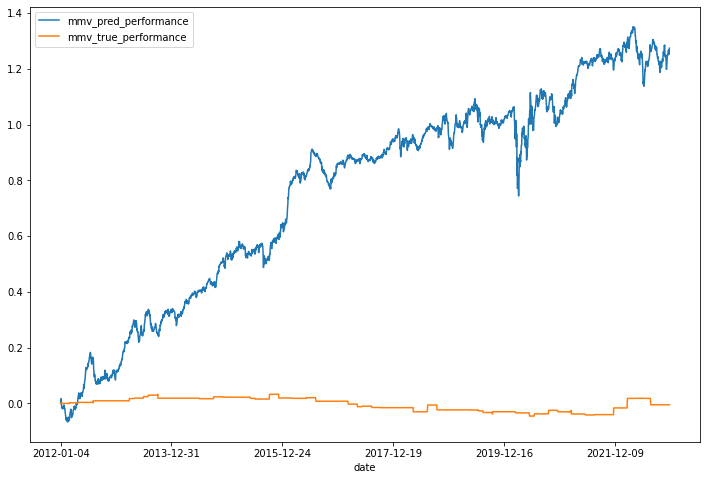

In [ ]:
mmv_performance = pd.DataFrame({'date':eval_tday_list,
                                'mmv_pred_performance':mmv_pred_performance_list,
                                'mmv_true_performance':mmv_true_performance_list}).set_index('date')
mmv_performance['mmv_pred_performance'].cumsum().plot(figsize=(12,8), label='mmv_pred_performance')
mmv_performance['mmv_true_performance'].cumsum().plot(figsize=(12,8), label='mmv_true_performance')
plt.legend()
plt.show()

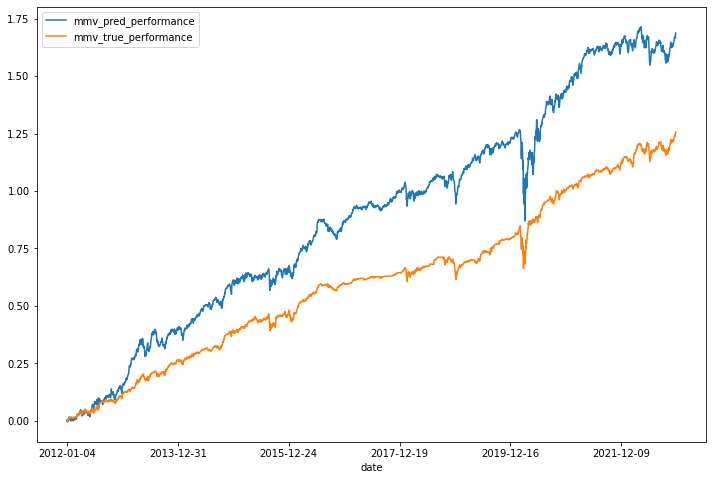

In [ ]:
mmv_long_only_performance = pd.DataFrame({'date':eval_tday_list,
                                'mmv_pred_long_only_performance':mmv_pred_long_only_performance_list,
                                'mmv_true_long_only_performance':mmv_true_long_only_performance_list}).set_index('date')
mmv_long_only_performance['mmv_pred_long_only_performance'].cumsum().plot(figsize=(12,8), label='mmv_pred_performance')
mmv_long_only_performance['mmv_true_long_only_performance'].cumsum().plot(figsize=(12,8), label='mmv_true_performance')
plt.legend()
plt.show()

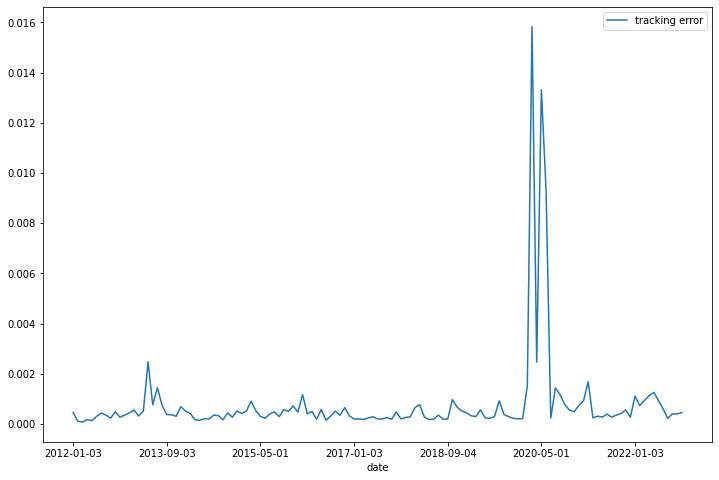

In [ ]:
tracking_error_df = pd.DataFrame({'date':month_list,
                                'tracking error':tracking_error_list}).set_index('date')
tracking_error_df.plot(figsize=(12,8), label='mmv_pred_performance')
plt.legend()
plt.show()

In [ ]:
tracking_error_df.to_csv('HAR_DRD_tracking_error.csv')

In [ ]:
mmv_long_only_performance.to_csv('HAR_DRD_MMV_LO_performance.csv')
mmv_performance.to_csv('HAR_DRD_MMV_performance.csv')

### Backtest for GHAR-DRD

In [ ]:
# each month start load the model (update and use the model for the result of the forecast)

eval_tday_list = []
mmv_pred_performance_list = []
mmv_true_performance_list = []
mmv_pred_long_only_performance_list = []
mmv_true_long_only_performance_list = []
tracking_error_list = []
month_list = []

dcp_error_month_list = []
dcp_error_long_only_month_list = []

for i, month_start in enumerate(tqdm(month_start_list[:-1])):
    # print(month_start)
    # load the month start model
    IS_WRV_model = OLSResults.load(f"model/IS_WRV_{month_start}.pkl")
    IS_x_model = OLSResults.load(f"model/IS_x_{month_start}.pkl")
    next_month_start = month_start_list[i+1]
    _, Ht_hat, _ = evaluate_prediction_GHAR_DRD(next_month_start, 
                                                  IS_WRV_model=IS_WRV_model, 
                                                  IS_x_model=IS_x_model)
    # Find Minimum Variance Portfolio
    try:
        w_hat = minVariance(Ht_hat, long_only=False)
    except DCPError:
        dcp_error_month_list.append(next_month_start)
        print(f'DCP Error on {next_month_start}')
    
    Ht, _, _, _ = engine.get_HAR_DRD(tday=next_month_start)
    w_true = minVariance(Ht, long_only=False)   # True Covariance Matrix for the month ending on next month start date

    # Find Minimum Variance Portfolio (Long Only)
    try:
        w_hat_long_only = minVariance(Ht_hat, long_only=True)
    except DCPError:
        dcp_error_long_only_month_list.append(next_month_start)
        print(f'DCP Error Long Only on {next_month_start}')
    
    w_true_long_only = minVariance(Ht, long_only=True)   # True Covariance Matrix for the month ending on next month start date
    tday_in_month = trading_day_list[np.logical_and(trading_day_list>month_start, 
                                                    trading_day_list<=next_month_start)]

    # Storage Tracking Errors
    tracking_error_list.append((w_hat_long_only-w_true_long_only).T@Ht@(w_hat_long_only-w_true_long_only))
    month_list.append(month_start)

    for tday in tday_in_month:
        tday = str(tday)
        eval_tday_list.append(tday)
        mmv_pred_performance_list.append(w_hat @ engine.ret_df.loc[tday].values)
        mmv_true_performance_list.append(w_true @ engine.ret_df.loc[tday].values)
        mmv_pred_long_only_performance_list.append(w_hat_long_only @ engine.ret_df.loc[tday].values)
        mmv_true_long_only_performance_list.append(w_true_long_only @ engine.ret_df.loc[tday].values)

  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
  4%|▍         | 5/131 [00:07<03:21,  1.60s/it]

DCP Error on 2012-06-01
DCP Error Long Only on 2012-06-01


  5%|▍         | 6/131 [00:09<03:19,  1.59s/it]

DCP Error on 2012-07-02
DCP Error Long Only on 2012-07-02


  5%|▌         | 7/131 [00:11<03:21,  1.62s/it]

DCP Error on 2012-08-01
DCP Error Long Only on 2012-08-01


 66%|██████▌   | 86/131 [02:02<00:59,  1.32s/it]

DCP Error on 2019-03-01
DCP Error Long Only on 2019-03-01


 67%|██████▋   | 88/131 [02:04<00:56,  1.30s/it]

DCP Error on 2019-05-01
DCP Error Long Only on 2019-05-01


 69%|██████▉   | 91/131 [02:08<00:52,  1.32s/it]

DCP Error on 2019-08-01
DCP Error Long Only on 2019-08-01


 71%|███████   | 93/131 [02:11<00:51,  1.35s/it]

DCP Error on 2019-11-01
DCP Error Long Only on 2019-11-01


100%|██████████| 131/131 [03:04<00:00,  1.41s/it]


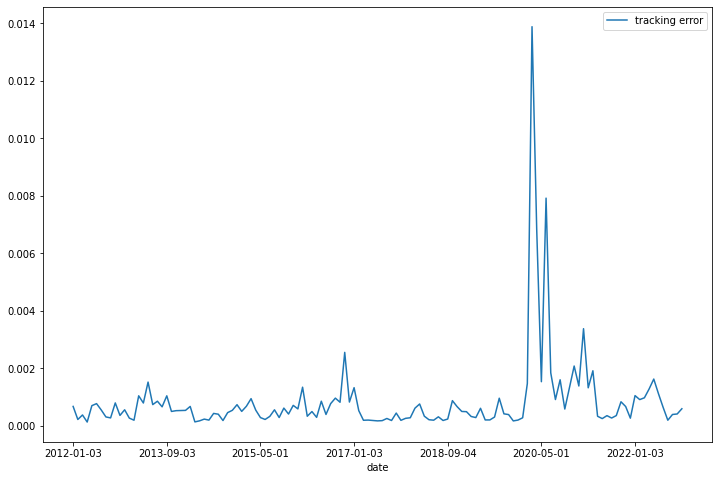

In [ ]:
tracking_error_df = pd.DataFrame({'date':month_list,
                                'tracking error':tracking_error_list}).set_index('date')
tracking_error_df.plot(figsize=(12,8), label='mmv_pred_performance')
plt.legend()
plt.show()

In [ ]:
tracking_error_df.to_csv('GHAR_DRD_tracking_error.csv')

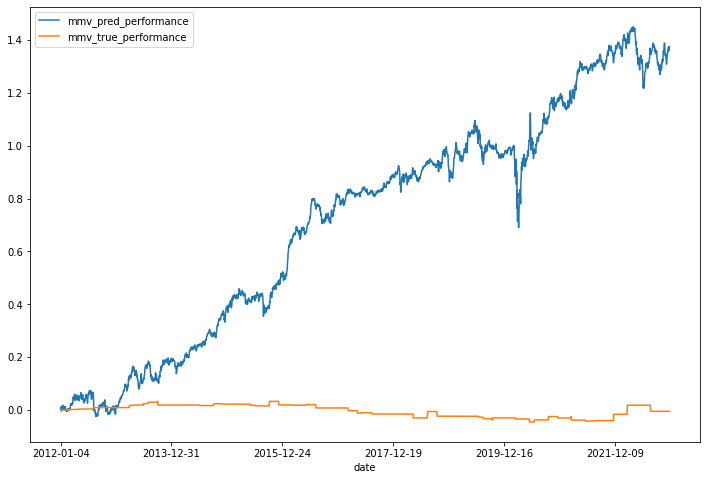

In [ ]:
mmv_performance = pd.DataFrame({'date':eval_tday_list,
                                'mmv_pred_performance':mmv_pred_performance_list,
                                'mmv_true_performance':mmv_true_performance_list}).set_index('date')
mmv_performance['mmv_pred_performance'].cumsum().plot(figsize=(12,8), label='mmv_pred_performance')
mmv_performance['mmv_true_performance'].cumsum().plot(figsize=(12,8), label='mmv_true_performance')
plt.legend()
plt.show()

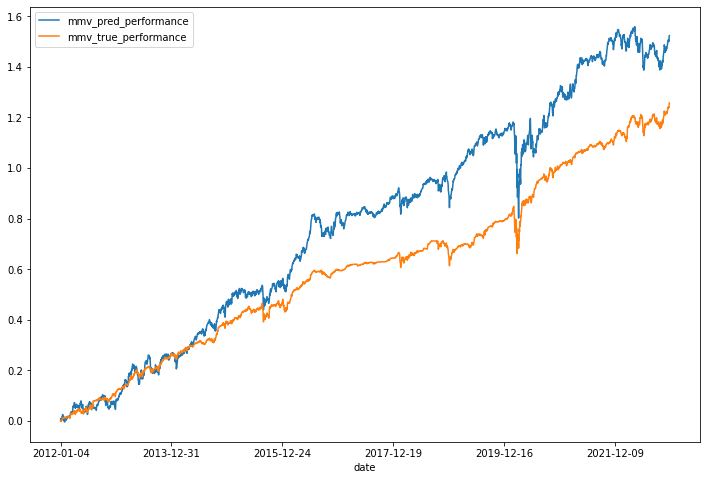

In [ ]:
mmv_long_only_performance = pd.DataFrame({'date':eval_tday_list,
                                'mmv_pred_long_only_performance':mmv_pred_long_only_performance_list,
                                'mmv_true_long_only_performance':mmv_true_long_only_performance_list}).set_index('date')
mmv_long_only_performance['mmv_pred_long_only_performance'].cumsum().plot(figsize=(12,8), label='mmv_pred_performance')
mmv_long_only_performance['mmv_true_long_only_performance'].cumsum().plot(figsize=(12,8), label='mmv_true_performance')
plt.legend()
plt.show()

In [ ]:
mmv_long_only_performance.to_csv('GHAR_DRD_MMV_LO_performance.csv')
mmv_performance.to_csv('GHAR_DRD_MMV_performance.csv')

### Simple Porfolio By Last Month's Covariance Matrix

In [ ]:
# each month start load the model (update and use the model for the result of the forecast)

eval_tday_list = []
mmv_pred_performance_list = []
mmv_true_performance_list = []
mmv_pred_long_only_performance_list = []
mmv_true_long_only_performance_list = []
tracking_error_list = []
month_list = []

dcp_error_month_list = []
dcp_error_long_only_month_list = []

for i, month_start in enumerate(tqdm(month_start_list[:-1])):
    next_month_start = month_start_list[i+1]
    Ht, _, _, _ = engine.get_HAR_DRD(next_month_start)
    Ht_hat, _, _, _ = engine.get_HAR_DRD(month_start)
    
    # Find Minimum Variance Portfolio
    try:
        w_hat = minVariance(Ht_hat, long_only=False)
    except DCPError:
        dcp_error_month_list.append(next_month_start)
        print(f'DCP Error on {next_month_start}')
    
    w_true = minVariance(Ht, long_only=False)   # True Covariance Matrix for the month ending on next month start date

    # Find Minimum Variance Portfolio (Long Only)
    try:
        w_hat_long_only = minVariance(Ht_hat, long_only=True)
    except DCPError:
        dcp_error_long_only_month_list.append(next_month_start)
        print(f'DCP Error Long Only on {next_month_start}')
    
    w_true_long_only = minVariance(Ht, long_only=True)   # True Covariance Matrix for the month ending on next month start date
    tday_in_month = trading_day_list[np.logical_and(trading_day_list>month_start, 
                                                    trading_day_list<=next_month_start)]
                                                    
    tracking_error_list.append((w_hat_long_only-w_true_long_only).T@Ht@(w_hat_long_only-w_true_long_only))
    month_list.append(month_start)

    for tday in tday_in_month:
        tday = str(tday)
        eval_tday_list.append(tday)
        mmv_pred_performance_list.append(w_hat @ engine.ret_df.loc[tday].values)
        mmv_true_performance_list.append(w_true @ engine.ret_df.loc[tday].values)
        mmv_pred_long_only_performance_list.append(w_hat_long_only @ engine.ret_df.loc[tday].values)
        mmv_true_long_only_performance_list.append(w_true_long_only @ engine.ret_df.loc[tday].values)

100%|██████████| 131/131 [00:34<00:00,  3.82it/s]


### Predicton using Bayesian Network Ht s


In [ ]:
with open('all_predicted_H_t.pkl','rb') as f:
    all_predicted_Ht = pickle.load(f)

In [ ]:
# def isPD(B):
#     """Returns true when input is positive-definite, via Cholesky"""
#     try:
#         _ = la.cholesky(B)
#         return True
#     except la.LinAlgError:
#         return False

# def nearestPD(A):
#     """Find the nearest positive-definite matrix to input

#     A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
#     credits [2].

#     [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

#     [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
#     matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
#     """

#     B = (A + A.T) / 2
#     _, s, V = la.svd(B)

#     H = np.dot(V.T, np.dot(np.diag(s), V))

#     A2 = (B + H) / 2

#     A3 = (A2 + A2.T) / 2

#     if isPD(A3):
#         return A3

#     spacing = np.spacing(la.norm(A))
#     # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
#     # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
#     # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
#     # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
#     # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
#     # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
#     # `spacing` will, for Gaussian random matrixes of small dimension, be on
#     # othe order of 1e-16. In practice, both ways converge, as the unit test
#     # below suggests.
#     I = np.eye(A.shape[0])
#     k = 1
#     while not isPD(A3):
#         mineig = np.min(np.real(la.eigvals(A3)))
#         A3 += I * (-mineig * k**2 + spacing)
#         k += 1

#     return A3

In [ ]:
# each month start load the model (update and use the model for the result of the forecast)

eval_tday_list = []
mmv_pred_performance_list = []
mmv_true_performance_list = []
mmv_pred_long_only_performance_list = []
mmv_true_long_only_performance_list = []
tracking_error_list = []
month_list = []

dcp_error_month_list = []
dcp_error_long_only_month_list = []

for i, month_start in enumerate(tqdm(month_start_list[:-1])):
    next_month_start = month_start_list[i+1]
    Ht_hat = all_predicted_Ht[month_start]
    if not is_pos_def(Ht_hat):
        Eigenvalues, Eigenvectors = la.eig(Ht_hat)
        Ht_hat += (-np.min(Eigenvalues) * np.identity(Eigenvalues.shape[0]))

    # Find Minimum Variance Portfolio
    try:
        w_hat = minVariance(Ht_hat, long_only=False)
    except DCPError:
        dcp_error_month_list.append(next_month_start)
        print(f'DCP Error on {next_month_start}')
    
    Ht, _, _, _ = engine.get_HAR_DRD(tday=next_month_start)
    w_true = minVariance(Ht, long_only=False)   # True Covariance Matrix for the month ending on next month start date

    # Find Minimum Variance Portfolio (Long Only)
    try:
        w_hat_long_only = minVariance(Ht_hat, long_only=True)
    except DCPError:
        dcp_error_long_only_month_list.append(next_month_start)
        print(f'DCP Error Long Only on {next_month_start}')
    
    w_true_long_only = minVariance(Ht, long_only=True)   # True Covariance Matrix for the month ending on next month start date
    tday_in_month = trading_day_list[np.logical_and(trading_day_list>month_start, 
                                                    trading_day_list<=next_month_start)]
    
    tracking_error_list.append((w_hat_long_only-w_true_long_only).T@Ht@(w_hat_long_only-w_true_long_only))
    month_list.append(month_start)
    for tday in tday_in_month:
        tday = str(tday)
        # print(tday)
        eval_tday_list.append(tday)
        mmv_pred_performance_list.append(w_hat @ engine.ret_df.loc[tday].values)
        mmv_true_performance_list.append(w_true @ engine.ret_df.loc[tday].values)
        mmv_pred_long_only_performance_list.append(w_hat_long_only @ engine.ret_df.loc[tday].values)
        mmv_true_long_only_performance_list.append(w_true_long_only @ engine.ret_df.loc[tday].values)


100%|██████████| 131/131 [00:29<00:00,  4.49it/s]


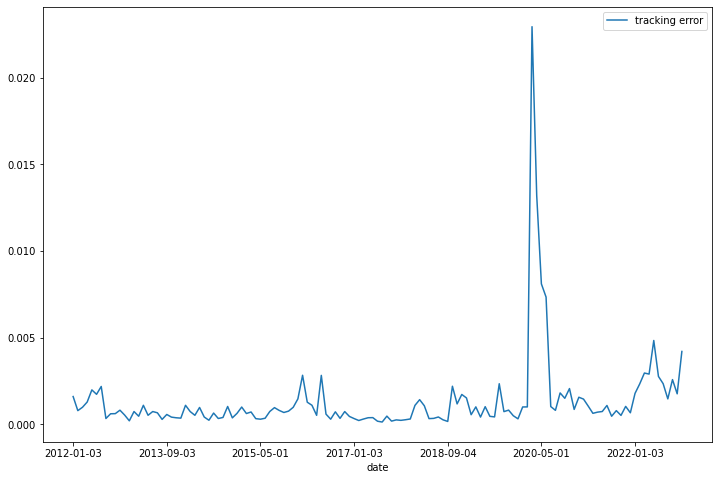

In [ ]:
tracking_error_df = pd.DataFrame({'date':month_list,
                                'tracking error':tracking_error_list}).set_index('date')
tracking_error_df.plot(figsize=(12,8), label='mmv_pred_performance')
plt.legend()
plt.show()

In [ ]:
tracking_error_df.to_csv('BN_tracking_error.csv')

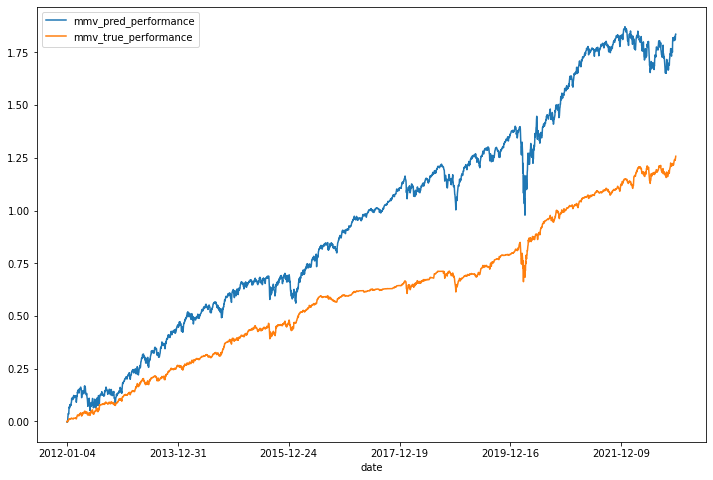

In [ ]:
mmv_long_only_performance = pd.DataFrame({'date':eval_tday_list,
                                'mmv_pred_long_only_performance':mmv_pred_long_only_performance_list,
                                'mmv_true_long_only_performance':mmv_true_long_only_performance_list}).set_index('date')
mmv_long_only_performance['mmv_pred_long_only_performance'].cumsum().plot(figsize=(12,8), label='mmv_pred_performance')
mmv_long_only_performance['mmv_true_long_only_performance'].cumsum().plot(figsize=(12,8), label='mmv_true_performance')
plt.legend()
plt.show()

In [ ]:
mmv_long_only_performance.std()

mmv_pred_long_only_performance    0.011358
mmv_true_long_only_performance    0.005304
dtype: float64

In [ ]:
mmv_long_only_performance.to_csv('BN_MMV_LO_performance.csv')

In [ ]:
HAR_DRD_MMV_long_only_performance = pd.read_csv('HAR_DRD_MMV_LO_performance.csv') # .set_index('date')
GHAR_DRD_MMV_long_only_performance = pd.read_csv('GHAR_DRD_MMV_LO_performance.csv') # .set_index('date')
PAST_MMV_long_only_performance = pd.read_csv('Past_Cov_MMV_LO_performance.csv').iloc[:,:2]
BN_MMV_long_only_performance = pd.read_csv('BN_MMV_LO_performance.csv').iloc[:,:2]

In [ ]:
HAR_DRD_MMV_long_only_performance.columns = ['date', 'MMV HAR_DRD', 'MMV True']
GHAR_DRD_MMV_long_only_performance.columns = ['date', 'MMV GHAR_DRD', 'MMV True']
PAST_MMV_long_only_performance.columns = ['date', 'MMV Previous Month']
BN_MMV_long_only_performance.columns = ['date', 'MMV Bayesian Network']

In [ ]:
# HAR_DRD_MMV_long_only_performance.set_index('date').plot()

In [ ]:
mmv_performance_df = pd.merge(HAR_DRD_MMV_long_only_performance,GHAR_DRD_MMV_long_only_performance[['date', 'MMV GHAR_DRD']], on='date')
mmv_performance_df = pd.merge(mmv_performance_df,PAST_MMV_long_only_performance, on='date')
mmv_performance_df = pd.merge(mmv_performance_df,BN_MMV_long_only_performance, on='date')
mmv_performance_df['date'] = pd.to_datetime(mmv_performance_df['date'])
mmv_performance_df = mmv_performance_df.set_index('date')
mmv_performance_df = mmv_performance_df[['MMV HAR_DRD', 'MMV GHAR_DRD', 'MMV Previous Month', 'MMV Bayesian Network', 'MMV True']]

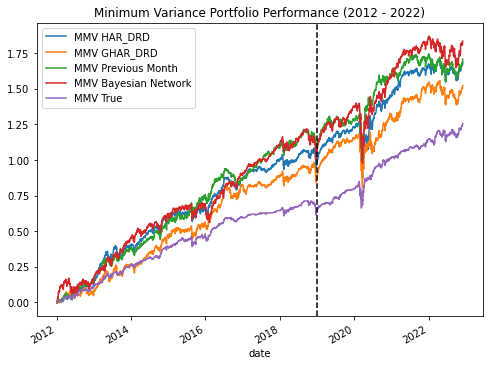

In [ ]:
mmv_performance_df.cumsum().plot(figsize=(8,6),title='Minimum Variance Portfolio Performance (2012 - 2022)')
plt.axvline(pd.to_datetime('2018-12-31'),color='k', linestyle='--');

In [ ]:
mmv_performance_df.std()

MMV HAR_DRD             0.009379
MMV GHAR_DRD            0.009505
MMV Previous Month      0.009671
MMV Bayesian Network    0.011358
MMV True                0.005304
dtype: float64

In [19]:
# Relative Ranking over time
# correlation of losses

HAR_DRD_tracking_error = pd.read_csv('HAR_DRD_tracking_error.csv').set_index('date')
GHAR_DRD_tracking_error = pd.read_csv('GHAR_DRD_tracking_error.csv').set_index('date')
Past_Cov_tracking_error = pd.read_csv('Past_Cov_tracking_error.csv').set_index('date')
BN_tracking_error = pd.read_csv('BN_tracking_error.csv').set_index('date')

In [20]:
# HAR_DRD_tracking_error.colums = ['HAR DRD']
# GHAR_DRD_tracking_error.columns = ['GHAR DRD']
# Past_Cov_tracking_error.columns = ['Previous Month']
BN_tracking_error.columns = ['Bayesian Network']

tracking_error = BN_tracking_error.copy()
tracking_error['HAR DRD'] = HAR_DRD_tracking_error['tracking error']
tracking_error['GHAR DRD'] = GHAR_DRD_tracking_error['tracking error']
tracking_error['Previous Month'] = Past_Cov_tracking_error['tracking error']
# tracking_error

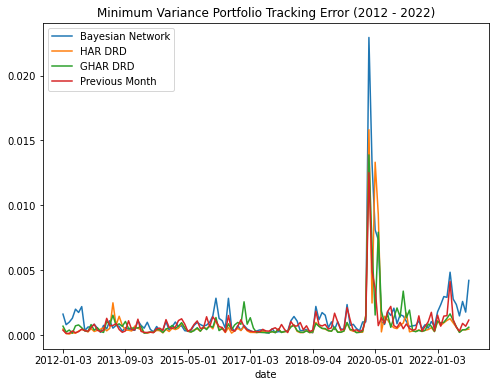

In [22]:
tracking_error.plot(figsize=(8,6),title='Minimum Variance Portfolio Tracking Error (2012 - 2022)');

In [23]:
tracking_error['year'] = tracking_error.index.str[:4]

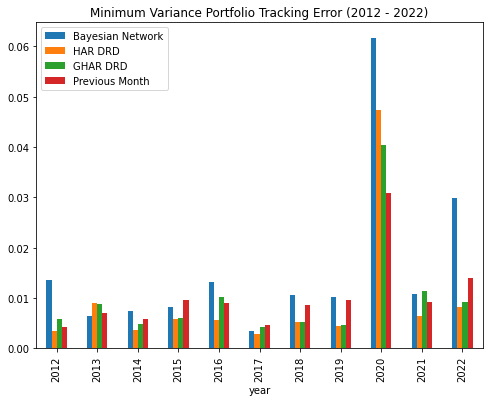

In [24]:
tracking_error.groupby('year').sum().plot.bar(figsize=(8,6),title='Minimum Variance Portfolio Tracking Error (2012 - 2022)');